# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

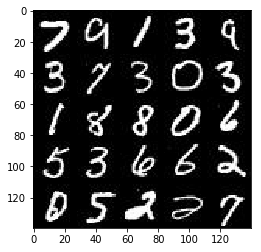

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

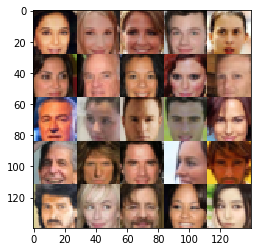

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim))
    lr = tf.placeholder(tf.float32)
    return input_real, input_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    filter1, filter2, filter3 = 64, 128, 256
    kernel = 5
    strides = 2
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse = reuse):
        # 28x28xchannel
        layer1 = tf.layers.conv2d(images, filter1, kernel, strides, padding  = 'same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        #14x14x64
        
        layer2 = tf.layers.conv2d(relu1, filter2, kernel, strides, padding = 'same')
        bn2 = tf.layers.batch_normalization(layer2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7x7x128
        
        layer3 = tf.layers.conv2d(relu2, filter3, kernel, 1, padding = 'same')
        bn3 = tf.layers.batch_normalization(layer3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 7 * 7 * filter3))

        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.1
    filter1, filter2 = 256, 128
    kernel = 5
    strides = 2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        flat = tf.layers.dense(z, 7 * 7 * 512)
        
        layer1 = tf.reshape(flat, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(layer1, training = is_train)
        relu1 = tf.maximum(bn1 * alpha, bn1)
        # 7x7x256
        
        layer2 = tf.layers.conv2d_transpose(relu1, filter1, kernel, strides, padding = 'same')
        bn2 = tf.layers.batch_normalization(layer2, training = is_train)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        # 14x14x128
        
        layer3 = tf.layers.conv2d_transpose(relu2, filter2, kernel, strides, padding = 'same')
        bn3 = tf.layers.batch_normalization(layer3, training = is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, kernel, 1, padding = 'same')
        
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_fake = generator(input_z, out_channel_dim, is_train = True)
    real_output, real_logits = discriminator(input_real)
    fake_output, fake_logits = discriminator(input_fake, reuse = True)
    
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(fake_output), logits = fake_logits))
    
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(real_output), logits = real_logits))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(fake_output), logits = fake_logits))

    d_loss = d_fake_loss + d_real_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_op = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_op = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_op, g_train_op = model_opt(d_loss, g_loss, lr, beta1)
    
    n_batch = 0
    losses = []
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                n_batch += 1
                # TODO: Train Model
                batch_images *= 2 # Scale the images to -1 to 1
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_train_op, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_op, feed_dict = {input_z: batch_z, lr: learning_rate})
                
                if n_batch % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                    losses.append([train_loss_d, train_loss_g])
                
                if n_batch % 100 == 0:                    
                    show_generator_output(sess, 72, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.5537... Generator Loss: 1.2015
Epoch 0/2... Discriminator Loss: 3.7469... Generator Loss: 0.0336
Epoch 0/2... Discriminator Loss: 1.1068... Generator Loss: 3.2136
Epoch 0/2... Discriminator Loss: 0.2864... Generator Loss: 3.7892
Epoch 0/2... Discriminator Loss: 0.8369... Generator Loss: 2.8796
Epoch 0/2... Discriminator Loss: 0.8292... Generator Loss: 1.5728
Epoch 0/2... Discriminator Loss: 1.3589... Generator Loss: 0.7176
Epoch 0/2... Discriminator Loss: 0.9931... Generator Loss: 1.0555
Epoch 0/2... Discriminator Loss: 1.0369... Generator Loss: 0.9352
Epoch 0/2... Discriminator Loss: 1.6081... Generator Loss: 0.3545


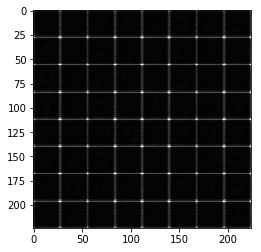

Epoch 0/2... Discriminator Loss: 1.7964... Generator Loss: 0.2872
Epoch 0/2... Discriminator Loss: 1.5381... Generator Loss: 0.5895
Epoch 0/2... Discriminator Loss: 1.5648... Generator Loss: 0.4122
Epoch 0/2... Discriminator Loss: 1.5102... Generator Loss: 0.6020
Epoch 0/2... Discriminator Loss: 1.8385... Generator Loss: 0.2387
Epoch 0/2... Discriminator Loss: 1.1213... Generator Loss: 0.8616
Epoch 0/2... Discriminator Loss: 1.0082... Generator Loss: 0.9626
Epoch 0/2... Discriminator Loss: 1.3251... Generator Loss: 0.6436
Epoch 0/2... Discriminator Loss: 1.2720... Generator Loss: 0.5164
Epoch 0/2... Discriminator Loss: 1.2153... Generator Loss: 0.7629


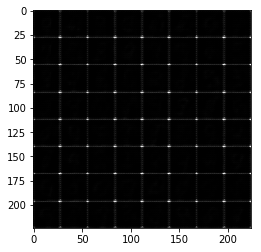

Epoch 0/2... Discriminator Loss: 1.3863... Generator Loss: 0.4432
Epoch 0/2... Discriminator Loss: 1.4567... Generator Loss: 0.3619
Epoch 0/2... Discriminator Loss: 1.0471... Generator Loss: 0.9702
Epoch 0/2... Discriminator Loss: 1.0364... Generator Loss: 0.8595
Epoch 0/2... Discriminator Loss: 1.3341... Generator Loss: 0.4928
Epoch 0/2... Discriminator Loss: 1.1497... Generator Loss: 0.7960
Epoch 0/2... Discriminator Loss: 0.8887... Generator Loss: 1.5481
Epoch 0/2... Discriminator Loss: 0.9981... Generator Loss: 0.9420
Epoch 0/2... Discriminator Loss: 1.1266... Generator Loss: 0.7801
Epoch 0/2... Discriminator Loss: 1.6641... Generator Loss: 0.2814


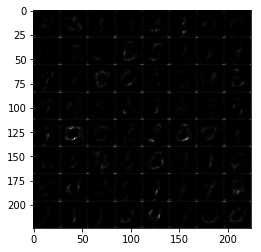

Epoch 0/2... Discriminator Loss: 1.6272... Generator Loss: 0.3641
Epoch 0/2... Discriminator Loss: 1.2946... Generator Loss: 0.4852
Epoch 0/2... Discriminator Loss: 1.5579... Generator Loss: 0.3744
Epoch 0/2... Discriminator Loss: 1.2846... Generator Loss: 0.9071
Epoch 0/2... Discriminator Loss: 1.2068... Generator Loss: 1.8552
Epoch 0/2... Discriminator Loss: 1.6303... Generator Loss: 0.3338
Epoch 0/2... Discriminator Loss: 1.0728... Generator Loss: 1.2953
Epoch 0/2... Discriminator Loss: 1.1466... Generator Loss: 1.3424
Epoch 0/2... Discriminator Loss: 1.8039... Generator Loss: 0.2432
Epoch 0/2... Discriminator Loss: 1.3364... Generator Loss: 0.4471


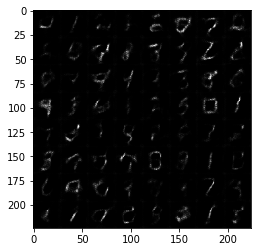

Epoch 0/2... Discriminator Loss: 1.4090... Generator Loss: 1.5685
Epoch 0/2... Discriminator Loss: 1.2592... Generator Loss: 0.5053
Epoch 0/2... Discriminator Loss: 1.1280... Generator Loss: 0.5963
Epoch 0/2... Discriminator Loss: 1.0702... Generator Loss: 1.4706
Epoch 0/2... Discriminator Loss: 1.1022... Generator Loss: 0.9469
Epoch 0/2... Discriminator Loss: 1.1984... Generator Loss: 0.9645
Epoch 0/2... Discriminator Loss: 1.4052... Generator Loss: 0.4672
Epoch 0/2... Discriminator Loss: 1.2168... Generator Loss: 0.4924
Epoch 0/2... Discriminator Loss: 1.1384... Generator Loss: 0.6514
Epoch 0/2... Discriminator Loss: 1.2451... Generator Loss: 0.7886


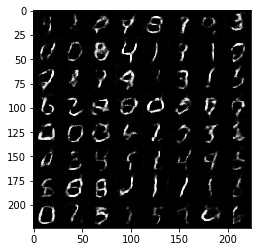

Epoch 0/2... Discriminator Loss: 1.2185... Generator Loss: 1.8444
Epoch 0/2... Discriminator Loss: 1.5082... Generator Loss: 0.4338
Epoch 0/2... Discriminator Loss: 1.2909... Generator Loss: 0.4097
Epoch 0/2... Discriminator Loss: 0.9137... Generator Loss: 1.3497
Epoch 0/2... Discriminator Loss: 1.0691... Generator Loss: 1.1468
Epoch 0/2... Discriminator Loss: 1.0791... Generator Loss: 1.4248
Epoch 0/2... Discriminator Loss: 1.0768... Generator Loss: 0.7438
Epoch 0/2... Discriminator Loss: 1.0940... Generator Loss: 0.8149
Epoch 0/2... Discriminator Loss: 1.2762... Generator Loss: 0.5413
Epoch 0/2... Discriminator Loss: 1.3570... Generator Loss: 1.8387


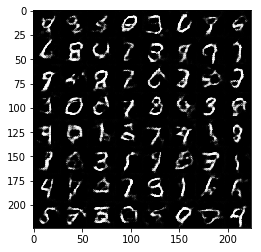

Epoch 0/2... Discriminator Loss: 1.1436... Generator Loss: 0.7066
Epoch 0/2... Discriminator Loss: 1.0358... Generator Loss: 0.8969
Epoch 0/2... Discriminator Loss: 1.0410... Generator Loss: 0.7457
Epoch 0/2... Discriminator Loss: 1.1149... Generator Loss: 1.2210
Epoch 0/2... Discriminator Loss: 1.7972... Generator Loss: 0.3112
Epoch 0/2... Discriminator Loss: 1.1662... Generator Loss: 0.7400
Epoch 0/2... Discriminator Loss: 1.3974... Generator Loss: 0.4229
Epoch 0/2... Discriminator Loss: 0.9764... Generator Loss: 1.4191
Epoch 0/2... Discriminator Loss: 1.1678... Generator Loss: 0.6245
Epoch 0/2... Discriminator Loss: 1.1184... Generator Loss: 0.7405


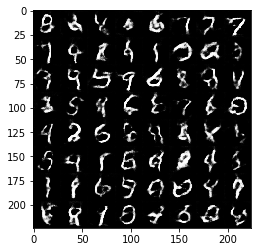

Epoch 0/2... Discriminator Loss: 0.8839... Generator Loss: 0.8413
Epoch 0/2... Discriminator Loss: 1.0662... Generator Loss: 0.6951
Epoch 0/2... Discriminator Loss: 1.0910... Generator Loss: 1.2061
Epoch 0/2... Discriminator Loss: 1.0372... Generator Loss: 1.1612
Epoch 0/2... Discriminator Loss: 0.9891... Generator Loss: 0.9089
Epoch 0/2... Discriminator Loss: 1.3825... Generator Loss: 0.4421
Epoch 0/2... Discriminator Loss: 0.7908... Generator Loss: 1.3523
Epoch 0/2... Discriminator Loss: 1.1659... Generator Loss: 0.6564
Epoch 0/2... Discriminator Loss: 1.0324... Generator Loss: 0.7602
Epoch 0/2... Discriminator Loss: 1.2904... Generator Loss: 0.4365


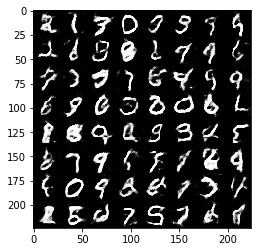

Epoch 0/2... Discriminator Loss: 1.0928... Generator Loss: 0.8094
Epoch 0/2... Discriminator Loss: 0.8875... Generator Loss: 0.9473
Epoch 0/2... Discriminator Loss: 1.7117... Generator Loss: 0.2610
Epoch 0/2... Discriminator Loss: 0.9730... Generator Loss: 0.7134
Epoch 0/2... Discriminator Loss: 1.0413... Generator Loss: 0.7236
Epoch 0/2... Discriminator Loss: 0.9735... Generator Loss: 0.8682
Epoch 0/2... Discriminator Loss: 1.0693... Generator Loss: 0.6405
Epoch 0/2... Discriminator Loss: 1.4163... Generator Loss: 0.4215
Epoch 0/2... Discriminator Loss: 1.0418... Generator Loss: 0.7438
Epoch 0/2... Discriminator Loss: 0.9621... Generator Loss: 0.6675


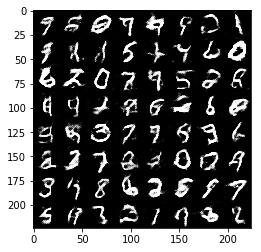

Epoch 0/2... Discriminator Loss: 0.9725... Generator Loss: 0.7356
Epoch 0/2... Discriminator Loss: 0.8866... Generator Loss: 1.3384
Epoch 0/2... Discriminator Loss: 0.9668... Generator Loss: 1.1908
Epoch 0/2... Discriminator Loss: 1.0218... Generator Loss: 0.9991
Epoch 0/2... Discriminator Loss: 1.0857... Generator Loss: 1.2061
Epoch 0/2... Discriminator Loss: 1.0894... Generator Loss: 0.6635
Epoch 0/2... Discriminator Loss: 1.2594... Generator Loss: 0.4788
Epoch 0/2... Discriminator Loss: 0.9198... Generator Loss: 0.9629
Epoch 0/2... Discriminator Loss: 1.7447... Generator Loss: 0.2663
Epoch 0/2... Discriminator Loss: 1.2519... Generator Loss: 0.4861


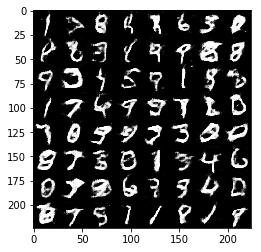

Epoch 0/2... Discriminator Loss: 0.7503... Generator Loss: 1.0142
Epoch 0/2... Discriminator Loss: 0.9458... Generator Loss: 0.7354
Epoch 0/2... Discriminator Loss: 0.9659... Generator Loss: 0.9141
Epoch 0/2... Discriminator Loss: 0.9156... Generator Loss: 0.8962
Epoch 0/2... Discriminator Loss: 1.0363... Generator Loss: 2.1456
Epoch 0/2... Discriminator Loss: 0.9414... Generator Loss: 0.9178
Epoch 0/2... Discriminator Loss: 1.2100... Generator Loss: 1.7565
Epoch 0/2... Discriminator Loss: 1.6820... Generator Loss: 2.6974
Epoch 0/2... Discriminator Loss: 0.7709... Generator Loss: 1.3199
Epoch 0/2... Discriminator Loss: 1.7034... Generator Loss: 0.2617


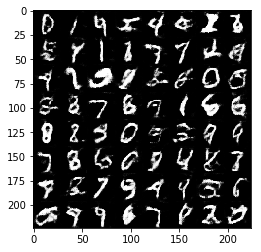

Epoch 0/2... Discriminator Loss: 0.9899... Generator Loss: 0.8137
Epoch 0/2... Discriminator Loss: 1.2057... Generator Loss: 0.5113
Epoch 0/2... Discriminator Loss: 1.4242... Generator Loss: 0.4553
Epoch 0/2... Discriminator Loss: 1.4602... Generator Loss: 1.7259
Epoch 0/2... Discriminator Loss: 0.8696... Generator Loss: 0.9784
Epoch 0/2... Discriminator Loss: 0.9161... Generator Loss: 1.0455
Epoch 0/2... Discriminator Loss: 0.8387... Generator Loss: 1.6276
Epoch 0/2... Discriminator Loss: 1.3216... Generator Loss: 1.7170
Epoch 0/2... Discriminator Loss: 0.9664... Generator Loss: 1.1333
Epoch 0/2... Discriminator Loss: 1.1563... Generator Loss: 0.6453


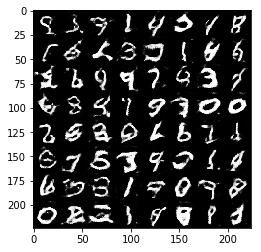

Epoch 0/2... Discriminator Loss: 0.7983... Generator Loss: 1.4275
Epoch 0/2... Discriminator Loss: 1.2549... Generator Loss: 0.5768
Epoch 0/2... Discriminator Loss: 1.2459... Generator Loss: 0.6473
Epoch 0/2... Discriminator Loss: 1.1413... Generator Loss: 0.5304
Epoch 0/2... Discriminator Loss: 1.2890... Generator Loss: 0.4486
Epoch 0/2... Discriminator Loss: 1.6754... Generator Loss: 0.2729
Epoch 0/2... Discriminator Loss: 1.0423... Generator Loss: 1.6699
Epoch 0/2... Discriminator Loss: 0.7803... Generator Loss: 1.6022
Epoch 0/2... Discriminator Loss: 1.2591... Generator Loss: 0.4525
Epoch 0/2... Discriminator Loss: 0.9417... Generator Loss: 1.3460


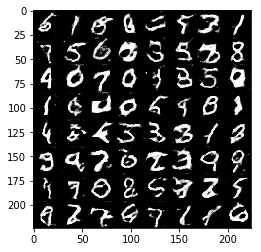

Epoch 0/2... Discriminator Loss: 1.2165... Generator Loss: 0.6340
Epoch 0/2... Discriminator Loss: 1.3248... Generator Loss: 0.5925
Epoch 0/2... Discriminator Loss: 1.2869... Generator Loss: 0.4859
Epoch 0/2... Discriminator Loss: 0.8122... Generator Loss: 0.8704
Epoch 0/2... Discriminator Loss: 0.9680... Generator Loss: 0.7506
Epoch 0/2... Discriminator Loss: 2.0484... Generator Loss: 0.2072
Epoch 0/2... Discriminator Loss: 0.8062... Generator Loss: 1.5022
Epoch 0/2... Discriminator Loss: 0.9196... Generator Loss: 2.0527
Epoch 0/2... Discriminator Loss: 1.2713... Generator Loss: 0.5330
Epoch 0/2... Discriminator Loss: 0.9395... Generator Loss: 0.7138


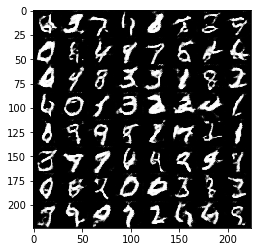

Epoch 0/2... Discriminator Loss: 0.7512... Generator Loss: 1.3817
Epoch 0/2... Discriminator Loss: 1.5231... Generator Loss: 0.3127
Epoch 0/2... Discriminator Loss: 0.9574... Generator Loss: 0.7149
Epoch 0/2... Discriminator Loss: 1.0639... Generator Loss: 0.5717
Epoch 0/2... Discriminator Loss: 1.6300... Generator Loss: 0.2912
Epoch 0/2... Discriminator Loss: 0.8652... Generator Loss: 0.8595
Epoch 0/2... Discriminator Loss: 0.9999... Generator Loss: 0.8795
Epoch 0/2... Discriminator Loss: 1.3133... Generator Loss: 0.4466
Epoch 0/2... Discriminator Loss: 1.3084... Generator Loss: 0.5482
Epoch 0/2... Discriminator Loss: 1.2370... Generator Loss: 0.6453


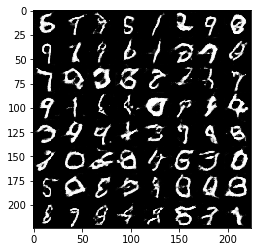

Epoch 0/2... Discriminator Loss: 0.9950... Generator Loss: 0.8478
Epoch 0/2... Discriminator Loss: 1.1070... Generator Loss: 0.5727
Epoch 0/2... Discriminator Loss: 1.5915... Generator Loss: 0.3260
Epoch 0/2... Discriminator Loss: 1.1341... Generator Loss: 0.6192
Epoch 0/2... Discriminator Loss: 0.9935... Generator Loss: 0.7100
Epoch 0/2... Discriminator Loss: 0.6783... Generator Loss: 1.2495
Epoch 0/2... Discriminator Loss: 0.7197... Generator Loss: 1.1639
Epoch 0/2... Discriminator Loss: 1.9418... Generator Loss: 0.2276
Epoch 0/2... Discriminator Loss: 1.1791... Generator Loss: 0.5362
Epoch 0/2... Discriminator Loss: 0.8209... Generator Loss: 1.6975


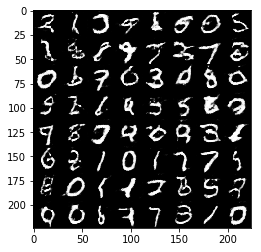

Epoch 0/2... Discriminator Loss: 1.0795... Generator Loss: 1.1049
Epoch 0/2... Discriminator Loss: 0.7107... Generator Loss: 1.2392
Epoch 0/2... Discriminator Loss: 0.8137... Generator Loss: 1.1363
Epoch 0/2... Discriminator Loss: 0.7529... Generator Loss: 1.6241
Epoch 0/2... Discriminator Loss: 0.7146... Generator Loss: 1.1131
Epoch 0/2... Discriminator Loss: 1.1611... Generator Loss: 0.6288
Epoch 0/2... Discriminator Loss: 0.9636... Generator Loss: 0.9105
Epoch 0/2... Discriminator Loss: 0.8277... Generator Loss: 1.0473
Epoch 0/2... Discriminator Loss: 0.7221... Generator Loss: 1.6530
Epoch 0/2... Discriminator Loss: 0.9084... Generator Loss: 0.7360


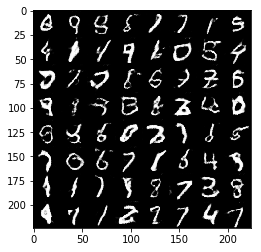

Epoch 0/2... Discriminator Loss: 0.5950... Generator Loss: 1.5186
Epoch 0/2... Discriminator Loss: 2.0178... Generator Loss: 0.2194
Epoch 0/2... Discriminator Loss: 0.5320... Generator Loss: 1.5582
Epoch 0/2... Discriminator Loss: 0.8542... Generator Loss: 0.9357
Epoch 0/2... Discriminator Loss: 1.0601... Generator Loss: 0.7148
Epoch 0/2... Discriminator Loss: 2.2422... Generator Loss: 0.1660
Epoch 0/2... Discriminator Loss: 0.9689... Generator Loss: 1.2267
Epoch 0/2... Discriminator Loss: 1.0097... Generator Loss: 0.6716
Epoch 0/2... Discriminator Loss: 0.9406... Generator Loss: 0.8016
Epoch 0/2... Discriminator Loss: 0.9238... Generator Loss: 1.4652


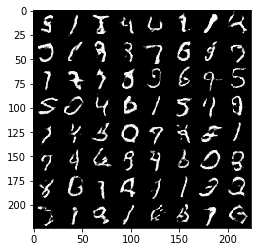

Epoch 0/2... Discriminator Loss: 0.9720... Generator Loss: 0.8646
Epoch 0/2... Discriminator Loss: 0.8033... Generator Loss: 0.8375
Epoch 0/2... Discriminator Loss: 1.0348... Generator Loss: 1.4067
Epoch 0/2... Discriminator Loss: 1.1651... Generator Loss: 0.5459
Epoch 0/2... Discriminator Loss: 1.7580... Generator Loss: 0.2825
Epoch 0/2... Discriminator Loss: 0.8420... Generator Loss: 0.8075
Epoch 0/2... Discriminator Loss: 1.6532... Generator Loss: 0.3482
Epoch 1/2... Discriminator Loss: 0.8134... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 0.9071... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 0.8192... Generator Loss: 0.9516


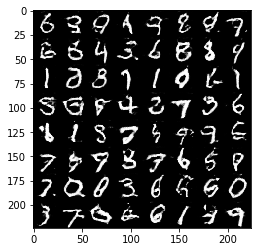

Epoch 1/2... Discriminator Loss: 0.6499... Generator Loss: 1.0789
Epoch 1/2... Discriminator Loss: 0.6570... Generator Loss: 1.3152
Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 1.2403
Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 1.5650
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 0.9076
Epoch 1/2... Discriminator Loss: 0.5016... Generator Loss: 1.3844
Epoch 1/2... Discriminator Loss: 1.0820... Generator Loss: 0.7305
Epoch 1/2... Discriminator Loss: 0.8630... Generator Loss: 1.1704
Epoch 1/2... Discriminator Loss: 1.6923... Generator Loss: 0.2769
Epoch 1/2... Discriminator Loss: 1.3779... Generator Loss: 0.4597


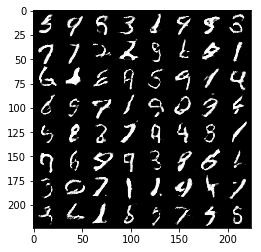

Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 1.6258
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 2.6018
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 1.7835
Epoch 1/2... Discriminator Loss: 0.6192... Generator Loss: 1.3737
Epoch 1/2... Discriminator Loss: 1.3165... Generator Loss: 0.5342
Epoch 1/2... Discriminator Loss: 1.8681... Generator Loss: 0.2919
Epoch 1/2... Discriminator Loss: 0.8789... Generator Loss: 0.9339
Epoch 1/2... Discriminator Loss: 2.1663... Generator Loss: 0.1809
Epoch 1/2... Discriminator Loss: 1.5413... Generator Loss: 0.3289
Epoch 1/2... Discriminator Loss: 2.3338... Generator Loss: 0.1653


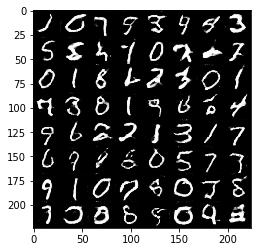

Epoch 1/2... Discriminator Loss: 0.7661... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 0.7414... Generator Loss: 1.0841
Epoch 1/2... Discriminator Loss: 0.6630... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 0.5783
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.5245
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 1.2649
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 0.5816


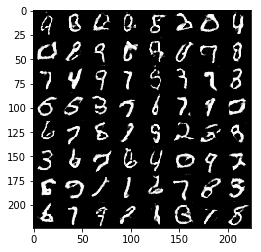

Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 1.2988
Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 0.9753
Epoch 1/2... Discriminator Loss: 1.7687... Generator Loss: 0.2663
Epoch 1/2... Discriminator Loss: 0.7445... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 0.6274... Generator Loss: 1.7722
Epoch 1/2... Discriminator Loss: 0.7260... Generator Loss: 2.3814
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 0.9505
Epoch 1/2... Discriminator Loss: 0.8547... Generator Loss: 1.0041
Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 1.2644
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 1.7653


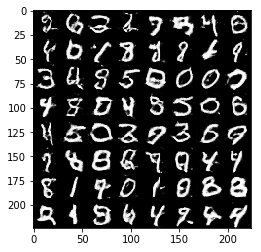

Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 1.5350
Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 0.6844... Generator Loss: 1.7261
Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 1.1257
Epoch 1/2... Discriminator Loss: 1.2935... Generator Loss: 2.2919
Epoch 1/2... Discriminator Loss: 0.7329... Generator Loss: 1.4989
Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 0.9390
Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 0.6850
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 0.9788... Generator Loss: 0.7475


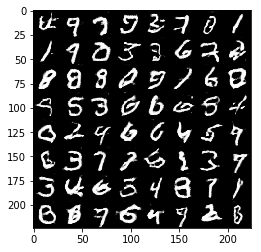

Epoch 1/2... Discriminator Loss: 0.7043... Generator Loss: 1.2878
Epoch 1/2... Discriminator Loss: 0.5701... Generator Loss: 1.3702
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.0041... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.5633
Epoch 1/2... Discriminator Loss: 0.7469... Generator Loss: 0.9133
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 0.5855
Epoch 1/2... Discriminator Loss: 2.2850... Generator Loss: 0.1789
Epoch 1/2... Discriminator Loss: 1.5850... Generator Loss: 0.3460


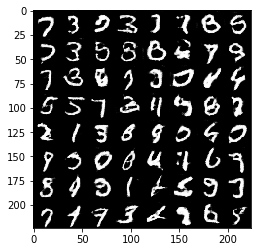

Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 0.8545... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 1.8507
Epoch 1/2... Discriminator Loss: 0.6248... Generator Loss: 1.4266
Epoch 1/2... Discriminator Loss: 0.7743... Generator Loss: 1.0275
Epoch 1/2... Discriminator Loss: 1.0747... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.6547
Epoch 1/2... Discriminator Loss: 0.6188... Generator Loss: 1.1798


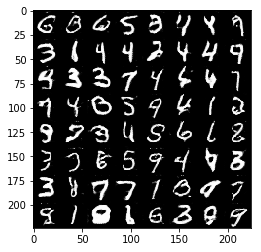

Epoch 1/2... Discriminator Loss: 0.7913... Generator Loss: 0.9333
Epoch 1/2... Discriminator Loss: 0.8891... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.6394... Generator Loss: 0.3452
Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 1.6568
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 0.7929
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 0.6377
Epoch 1/2... Discriminator Loss: 0.5309... Generator Loss: 1.5182
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 0.4220... Generator Loss: 2.4067


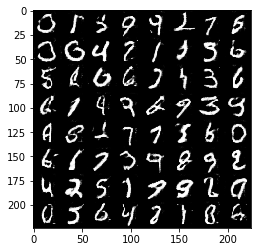

Epoch 1/2... Discriminator Loss: 0.4293... Generator Loss: 1.7912
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 0.4902... Generator Loss: 1.5179
Epoch 1/2... Discriminator Loss: 0.6158... Generator Loss: 1.4817
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 3.1402
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 0.6173... Generator Loss: 1.4601
Epoch 1/2... Discriminator Loss: 0.6825... Generator Loss: 1.1572
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.4076


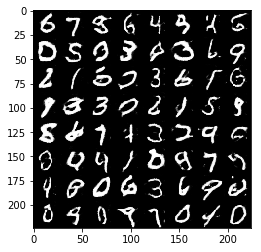

Epoch 1/2... Discriminator Loss: 0.6503... Generator Loss: 1.5875
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 0.7737... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 1.1956
Epoch 1/2... Discriminator Loss: 0.6137... Generator Loss: 1.4133
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.4564
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.3349
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.4956
Epoch 1/2... Discriminator Loss: 0.7923... Generator Loss: 1.2905
Epoch 1/2... Discriminator Loss: 0.6324... Generator Loss: 1.3022


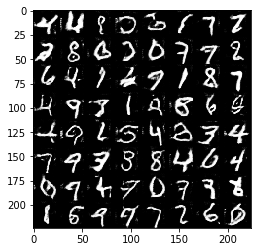

Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 1.9129
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 2.2667
Epoch 1/2... Discriminator Loss: 0.7681... Generator Loss: 0.9937
Epoch 1/2... Discriminator Loss: 0.8398... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 0.8624... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 0.6295... Generator Loss: 1.7650
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 0.9725


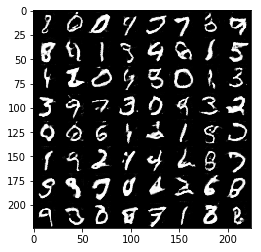

Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 1.1738
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.3836
Epoch 1/2... Discriminator Loss: 0.8086... Generator Loss: 0.8918
Epoch 1/2... Discriminator Loss: 1.7989... Generator Loss: 0.3033
Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 1.1092
Epoch 1/2... Discriminator Loss: 0.6387... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 0.4758
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 2.5441
Epoch 1/2... Discriminator Loss: 0.6813... Generator Loss: 1.2751


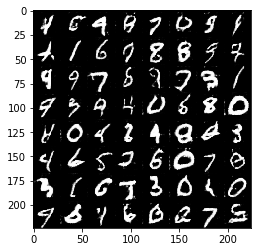

Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.5549
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 0.4775
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 0.6576
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 1.7289
Epoch 1/2... Discriminator Loss: 0.8694... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.7419
Epoch 1/2... Discriminator Loss: 0.6600... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 0.4135... Generator Loss: 2.3757
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 1.1598


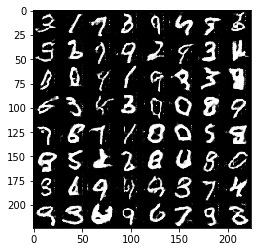

Epoch 1/2... Discriminator Loss: 1.5208... Generator Loss: 0.3590
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 0.9014
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 1.3462
Epoch 1/2... Discriminator Loss: 0.5599... Generator Loss: 1.2962
Epoch 1/2... Discriminator Loss: 0.4604... Generator Loss: 1.7199
Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 1.3576
Epoch 1/2... Discriminator Loss: 0.6579... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 2.2464
Epoch 1/2... Discriminator Loss: 0.6523... Generator Loss: 1.2731
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.5186


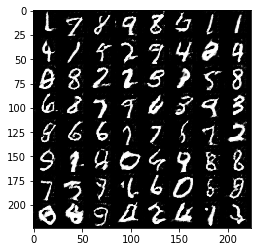

Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 0.5230... Generator Loss: 1.9618
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.7770
Epoch 1/2... Discriminator Loss: 0.6063... Generator Loss: 1.5715
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 2.5882
Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 0.6191... Generator Loss: 1.8145
Epoch 1/2... Discriminator Loss: 0.5108... Generator Loss: 1.8231
Epoch 1/2... Discriminator Loss: 0.4535... Generator Loss: 1.9597


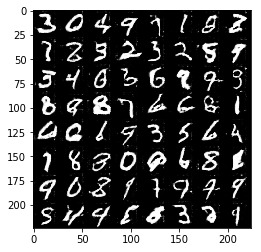

Epoch 1/2... Discriminator Loss: 0.6678... Generator Loss: 1.1687
Epoch 1/2... Discriminator Loss: 0.6147... Generator Loss: 1.6573
Epoch 1/2... Discriminator Loss: 0.4653... Generator Loss: 1.3527
Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 0.3973... Generator Loss: 1.7150
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 0.7111... Generator Loss: 0.9557
Epoch 1/2... Discriminator Loss: 0.5754... Generator Loss: 1.4561
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.5589


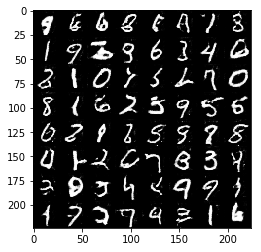

Epoch 1/2... Discriminator Loss: 0.8474... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 0.7005... Generator Loss: 1.2645
Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 0.5535
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 0.4402... Generator Loss: 1.9617
Epoch 1/2... Discriminator Loss: 0.7743... Generator Loss: 1.0523
Epoch 1/2... Discriminator Loss: 0.5289... Generator Loss: 1.2884
Epoch 1/2... Discriminator Loss: 0.5816... Generator Loss: 1.3065
Epoch 1/2... Discriminator Loss: 0.6005... Generator Loss: 1.8779
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 1.6545


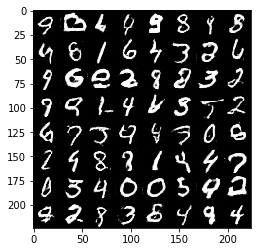

Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 0.8917... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 1.0434
Epoch 1/2... Discriminator Loss: 1.6502... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 1.3926
Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 2.0639
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.5489
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.4416
Epoch 1/2... Discriminator Loss: 0.3667... Generator Loss: 2.1116
Epoch 1/2... Discriminator Loss: 0.5301... Generator Loss: 2.0576


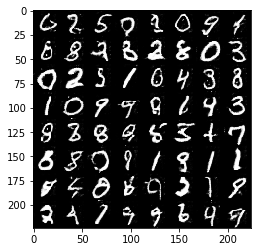

Epoch 1/2... Discriminator Loss: 0.6950... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.6166
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.4986
Epoch 1/2... Discriminator Loss: 0.8696... Generator Loss: 0.7839
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 3.0841


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.8083... Generator Loss: 1.1742
Epoch 0/1... Discriminator Loss: 1.1069... Generator Loss: 0.6230
Epoch 0/1... Discriminator Loss: 0.1707... Generator Loss: 4.9569
Epoch 0/1... Discriminator Loss: 1.5891... Generator Loss: 0.3808
Epoch 0/1... Discriminator Loss: 0.9881... Generator Loss: 3.2989
Epoch 0/1... Discriminator Loss: 1.0438... Generator Loss: 0.6194
Epoch 0/1... Discriminator Loss: 0.7863... Generator Loss: 1.0032
Epoch 0/1... Discriminator Loss: 0.9123... Generator Loss: 3.7370
Epoch 0/1... Discriminator Loss: 0.7054... Generator Loss: 1.1548
Epoch 0/1... Discriminator Loss: 1.0263... Generator Loss: 0.8124


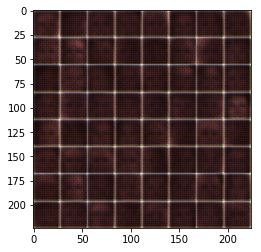

Epoch 0/1... Discriminator Loss: 0.3214... Generator Loss: 1.9420
Epoch 0/1... Discriminator Loss: 1.1870... Generator Loss: 7.5729
Epoch 0/1... Discriminator Loss: 0.6696... Generator Loss: 5.0062
Epoch 0/1... Discriminator Loss: 1.6841... Generator Loss: 6.1005
Epoch 0/1... Discriminator Loss: 1.0490... Generator Loss: 6.7232
Epoch 0/1... Discriminator Loss: 0.9894... Generator Loss: 0.6830
Epoch 0/1... Discriminator Loss: 0.2473... Generator Loss: 3.6322
Epoch 0/1... Discriminator Loss: 1.0038... Generator Loss: 0.9464
Epoch 0/1... Discriminator Loss: 0.9370... Generator Loss: 1.4210
Epoch 0/1... Discriminator Loss: 1.5677... Generator Loss: 0.4391


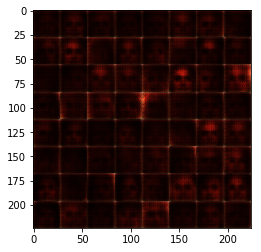

Epoch 0/1... Discriminator Loss: 0.9326... Generator Loss: 1.1427
Epoch 0/1... Discriminator Loss: 1.3905... Generator Loss: 3.5621
Epoch 0/1... Discriminator Loss: 1.1591... Generator Loss: 0.6708
Epoch 0/1... Discriminator Loss: 0.8261... Generator Loss: 3.0736
Epoch 0/1... Discriminator Loss: 1.3502... Generator Loss: 0.4124
Epoch 0/1... Discriminator Loss: 1.5201... Generator Loss: 0.3888
Epoch 0/1... Discriminator Loss: 1.0362... Generator Loss: 0.7806
Epoch 0/1... Discriminator Loss: 1.5369... Generator Loss: 4.8007
Epoch 0/1... Discriminator Loss: 0.5614... Generator Loss: 1.8855
Epoch 0/1... Discriminator Loss: 0.7680... Generator Loss: 0.9157


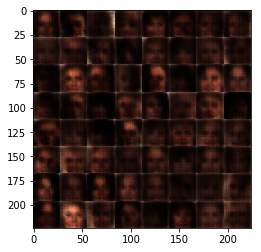

Epoch 0/1... Discriminator Loss: 1.0398... Generator Loss: 2.2600
Epoch 0/1... Discriminator Loss: 0.8100... Generator Loss: 2.0938
Epoch 0/1... Discriminator Loss: 1.3639... Generator Loss: 0.4158
Epoch 0/1... Discriminator Loss: 0.6510... Generator Loss: 3.0154
Epoch 0/1... Discriminator Loss: 0.7520... Generator Loss: 1.5807
Epoch 0/1... Discriminator Loss: 0.8265... Generator Loss: 1.2652
Epoch 0/1... Discriminator Loss: 1.7952... Generator Loss: 0.3261
Epoch 0/1... Discriminator Loss: 0.9942... Generator Loss: 0.7974
Epoch 0/1... Discriminator Loss: 1.1649... Generator Loss: 0.6558
Epoch 0/1... Discriminator Loss: 1.4454... Generator Loss: 0.4365


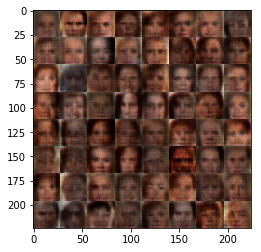

Epoch 0/1... Discriminator Loss: 1.1030... Generator Loss: 3.2462
Epoch 0/1... Discriminator Loss: 0.8174... Generator Loss: 1.7283
Epoch 0/1... Discriminator Loss: 1.1335... Generator Loss: 0.6172
Epoch 0/1... Discriminator Loss: 0.6582... Generator Loss: 2.6413
Epoch 0/1... Discriminator Loss: 0.3867... Generator Loss: 3.9252
Epoch 0/1... Discriminator Loss: 0.7250... Generator Loss: 1.2642
Epoch 0/1... Discriminator Loss: 1.2144... Generator Loss: 1.0194
Epoch 0/1... Discriminator Loss: 0.4869... Generator Loss: 2.6938
Epoch 0/1... Discriminator Loss: 0.9175... Generator Loss: 1.7107
Epoch 0/1... Discriminator Loss: 0.8386... Generator Loss: 1.0267


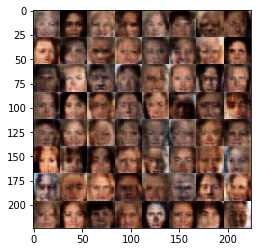

Epoch 0/1... Discriminator Loss: 1.2923... Generator Loss: 2.2325
Epoch 0/1... Discriminator Loss: 1.1011... Generator Loss: 0.8200
Epoch 0/1... Discriminator Loss: 1.2928... Generator Loss: 3.7191
Epoch 0/1... Discriminator Loss: 1.2416... Generator Loss: 0.5733
Epoch 0/1... Discriminator Loss: 0.7243... Generator Loss: 1.3930
Epoch 0/1... Discriminator Loss: 1.1343... Generator Loss: 0.6533
Epoch 0/1... Discriminator Loss: 0.8754... Generator Loss: 1.5667
Epoch 0/1... Discriminator Loss: 1.0887... Generator Loss: 1.7032
Epoch 0/1... Discriminator Loss: 0.7366... Generator Loss: 1.0934
Epoch 0/1... Discriminator Loss: 1.3709... Generator Loss: 1.3028


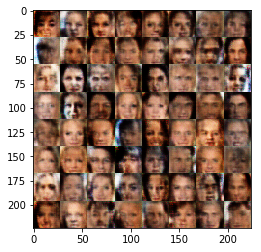

Epoch 0/1... Discriminator Loss: 1.1364... Generator Loss: 0.6981
Epoch 0/1... Discriminator Loss: 0.8858... Generator Loss: 0.9022
Epoch 0/1... Discriminator Loss: 1.0658... Generator Loss: 0.6347
Epoch 0/1... Discriminator Loss: 0.8261... Generator Loss: 0.9389
Epoch 0/1... Discriminator Loss: 1.1042... Generator Loss: 1.1169
Epoch 0/1... Discriminator Loss: 1.3232... Generator Loss: 1.7132
Epoch 0/1... Discriminator Loss: 1.1248... Generator Loss: 1.6673
Epoch 0/1... Discriminator Loss: 1.0683... Generator Loss: 1.1907
Epoch 0/1... Discriminator Loss: 1.5104... Generator Loss: 2.0644
Epoch 0/1... Discriminator Loss: 1.3716... Generator Loss: 1.0977


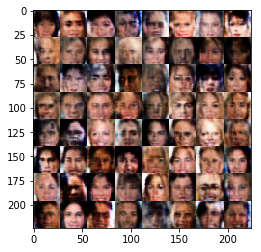

Epoch 0/1... Discriminator Loss: 0.4946... Generator Loss: 3.2988
Epoch 0/1... Discriminator Loss: 0.5319... Generator Loss: 3.7007
Epoch 0/1... Discriminator Loss: 1.1210... Generator Loss: 1.0483
Epoch 0/1... Discriminator Loss: 1.3036... Generator Loss: 0.4550
Epoch 0/1... Discriminator Loss: 1.3165... Generator Loss: 0.4711
Epoch 0/1... Discriminator Loss: 1.5346... Generator Loss: 0.3767
Epoch 0/1... Discriminator Loss: 1.1707... Generator Loss: 0.6269
Epoch 0/1... Discriminator Loss: 0.9060... Generator Loss: 0.7970
Epoch 0/1... Discriminator Loss: 1.4628... Generator Loss: 1.4852
Epoch 0/1... Discriminator Loss: 1.3319... Generator Loss: 0.7039


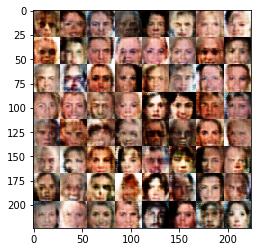

Epoch 0/1... Discriminator Loss: 0.7745... Generator Loss: 1.3785
Epoch 0/1... Discriminator Loss: 0.6418... Generator Loss: 1.7164
Epoch 0/1... Discriminator Loss: 0.5119... Generator Loss: 1.7241
Epoch 0/1... Discriminator Loss: 2.3324... Generator Loss: 0.1630
Epoch 0/1... Discriminator Loss: 1.0867... Generator Loss: 0.8524
Epoch 0/1... Discriminator Loss: 0.9245... Generator Loss: 0.8707
Epoch 0/1... Discriminator Loss: 1.3705... Generator Loss: 0.5698
Epoch 0/1... Discriminator Loss: 1.0194... Generator Loss: 0.8132
Epoch 0/1... Discriminator Loss: 1.2337... Generator Loss: 0.4967
Epoch 0/1... Discriminator Loss: 1.4512... Generator Loss: 0.4319


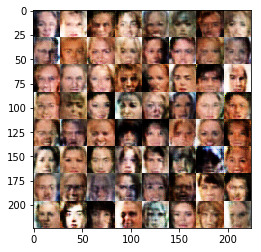

Epoch 0/1... Discriminator Loss: 1.0906... Generator Loss: 0.7053
Epoch 0/1... Discriminator Loss: 1.3326... Generator Loss: 3.2337
Epoch 0/1... Discriminator Loss: 1.0536... Generator Loss: 1.1603
Epoch 0/1... Discriminator Loss: 1.1701... Generator Loss: 1.1232
Epoch 0/1... Discriminator Loss: 1.4740... Generator Loss: 0.6869
Epoch 0/1... Discriminator Loss: 1.1968... Generator Loss: 0.6101
Epoch 0/1... Discriminator Loss: 0.9262... Generator Loss: 0.7912
Epoch 0/1... Discriminator Loss: 1.4368... Generator Loss: 1.0229
Epoch 0/1... Discriminator Loss: 1.2000... Generator Loss: 0.6179
Epoch 0/1... Discriminator Loss: 1.1838... Generator Loss: 0.6719


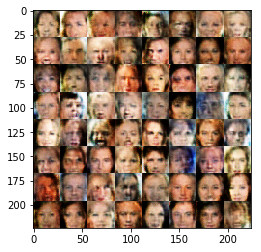

Epoch 0/1... Discriminator Loss: 1.2664... Generator Loss: 0.5075
Epoch 0/1... Discriminator Loss: 1.4598... Generator Loss: 0.3869
Epoch 0/1... Discriminator Loss: 0.7840... Generator Loss: 1.6666
Epoch 0/1... Discriminator Loss: 1.0273... Generator Loss: 1.9290
Epoch 0/1... Discriminator Loss: 0.9453... Generator Loss: 0.6937
Epoch 0/1... Discriminator Loss: 1.6487... Generator Loss: 0.3622
Epoch 0/1... Discriminator Loss: 1.3262... Generator Loss: 0.5113
Epoch 0/1... Discriminator Loss: 1.3724... Generator Loss: 0.4274
Epoch 0/1... Discriminator Loss: 1.2853... Generator Loss: 0.4646
Epoch 0/1... Discriminator Loss: 1.1424... Generator Loss: 1.8855


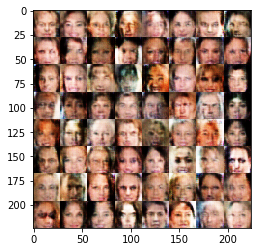

Epoch 0/1... Discriminator Loss: 0.8783... Generator Loss: 1.2460
Epoch 0/1... Discriminator Loss: 1.1702... Generator Loss: 0.5377
Epoch 0/1... Discriminator Loss: 0.9500... Generator Loss: 2.4338
Epoch 0/1... Discriminator Loss: 0.8898... Generator Loss: 1.1961
Epoch 0/1... Discriminator Loss: 1.1123... Generator Loss: 3.1693
Epoch 0/1... Discriminator Loss: 1.4488... Generator Loss: 0.3404
Epoch 0/1... Discriminator Loss: 1.2781... Generator Loss: 2.5806
Epoch 0/1... Discriminator Loss: 1.0986... Generator Loss: 1.1801
Epoch 0/1... Discriminator Loss: 0.9513... Generator Loss: 1.4637
Epoch 0/1... Discriminator Loss: 1.2281... Generator Loss: 0.5132


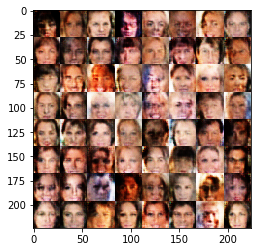

Epoch 0/1... Discriminator Loss: 1.1422... Generator Loss: 0.6441
Epoch 0/1... Discriminator Loss: 1.5815... Generator Loss: 0.4478
Epoch 0/1... Discriminator Loss: 1.5292... Generator Loss: 1.6532
Epoch 0/1... Discriminator Loss: 1.1556... Generator Loss: 0.8869
Epoch 0/1... Discriminator Loss: 1.1003... Generator Loss: 1.8426
Epoch 0/1... Discriminator Loss: 1.0608... Generator Loss: 0.8882
Epoch 0/1... Discriminator Loss: 0.8343... Generator Loss: 0.7674
Epoch 0/1... Discriminator Loss: 0.6675... Generator Loss: 3.1431
Epoch 0/1... Discriminator Loss: 1.5313... Generator Loss: 0.3791
Epoch 0/1... Discriminator Loss: 1.2838... Generator Loss: 0.5798


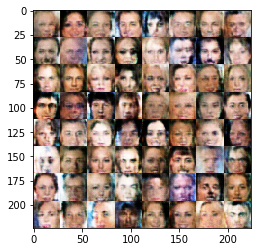

Epoch 0/1... Discriminator Loss: 1.5066... Generator Loss: 0.3785
Epoch 0/1... Discriminator Loss: 1.1986... Generator Loss: 0.6761
Epoch 0/1... Discriminator Loss: 1.1997... Generator Loss: 0.9243
Epoch 0/1... Discriminator Loss: 1.1665... Generator Loss: 0.6814
Epoch 0/1... Discriminator Loss: 0.9588... Generator Loss: 0.8774
Epoch 0/1... Discriminator Loss: 1.2902... Generator Loss: 0.6822
Epoch 0/1... Discriminator Loss: 0.7934... Generator Loss: 1.2184
Epoch 0/1... Discriminator Loss: 1.6762... Generator Loss: 0.2668
Epoch 0/1... Discriminator Loss: 1.5071... Generator Loss: 1.7025
Epoch 0/1... Discriminator Loss: 1.4800... Generator Loss: 0.4126


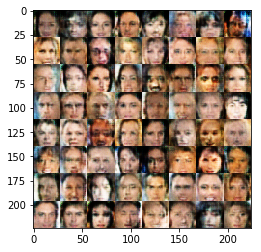

Epoch 0/1... Discriminator Loss: 2.0891... Generator Loss: 0.1892
Epoch 0/1... Discriminator Loss: 1.0888... Generator Loss: 2.0233
Epoch 0/1... Discriminator Loss: 1.0046... Generator Loss: 1.0606
Epoch 0/1... Discriminator Loss: 1.5338... Generator Loss: 0.5638
Epoch 0/1... Discriminator Loss: 1.0739... Generator Loss: 0.5804
Epoch 0/1... Discriminator Loss: 0.3320... Generator Loss: 2.0735
Epoch 0/1... Discriminator Loss: 1.0680... Generator Loss: 0.7242
Epoch 0/1... Discriminator Loss: 1.6270... Generator Loss: 0.3112
Epoch 0/1... Discriminator Loss: 1.1930... Generator Loss: 0.6017
Epoch 0/1... Discriminator Loss: 1.1499... Generator Loss: 1.2129


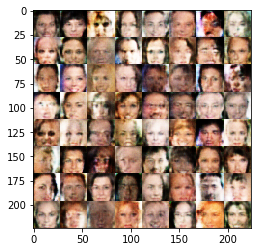

Epoch 0/1... Discriminator Loss: 1.1736... Generator Loss: 0.6624
Epoch 0/1... Discriminator Loss: 0.8988... Generator Loss: 1.1164
Epoch 0/1... Discriminator Loss: 1.3522... Generator Loss: 0.8988
Epoch 0/1... Discriminator Loss: 0.6750... Generator Loss: 1.7697
Epoch 0/1... Discriminator Loss: 1.2680... Generator Loss: 1.0464
Epoch 0/1... Discriminator Loss: 1.1969... Generator Loss: 1.3458
Epoch 0/1... Discriminator Loss: 1.1088... Generator Loss: 0.9184
Epoch 0/1... Discriminator Loss: 1.1800... Generator Loss: 0.6116


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.